In [3]:
%pip install concrete-ml
%pip install kagglehub[pandas-datasets]
%pip install kagglehub
%pip install seaborn
%pip install imblearn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Loading credit card fraud dataset...
Dataset shape: (284807, 31)
Fraud cases: 492 (0.17%)
Preprocessing data...
Training set: (227845, 30), Test set: (56962, 30)

Performing grid search for optimal parameters...

Grid search for LR...
Performing grid search for LR model...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.9066

Grid search for RF...
Performing grid search for RF model...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'max_depth': 7, 'min_samples_leaf': 3, 'n_estimators': 100}
Best score: 0.9093

Grid search for DT...
Performing grid search for DT model...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best score: 0.8987

Best parameters:
LR: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
RF: {'max_depth': 7, 'min_samples_leaf': 3, 'n_estimators': 100

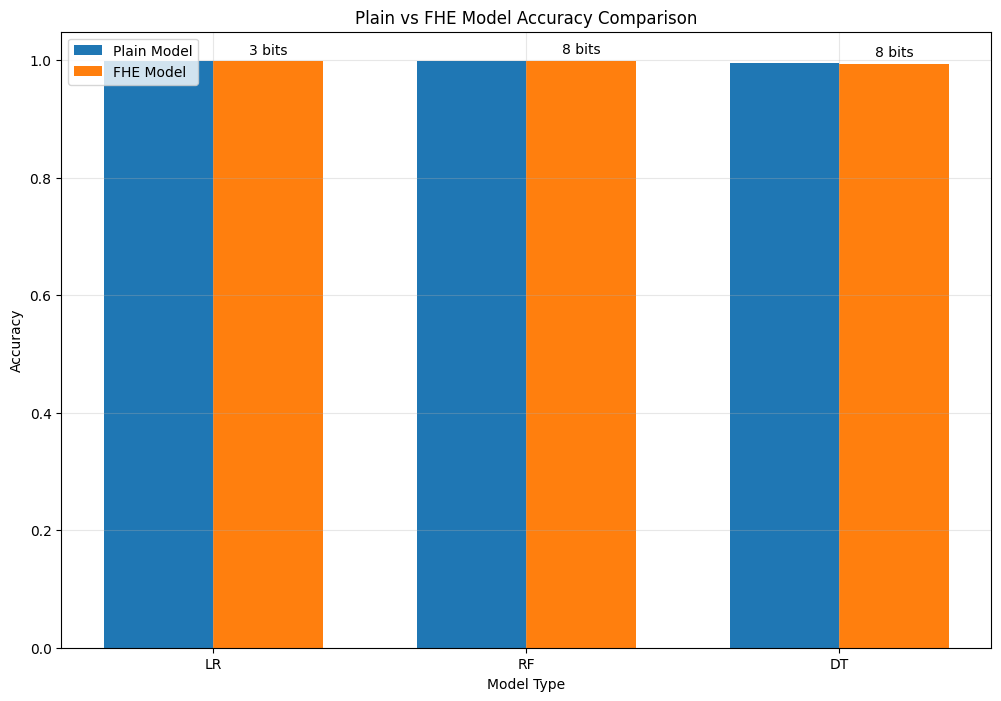

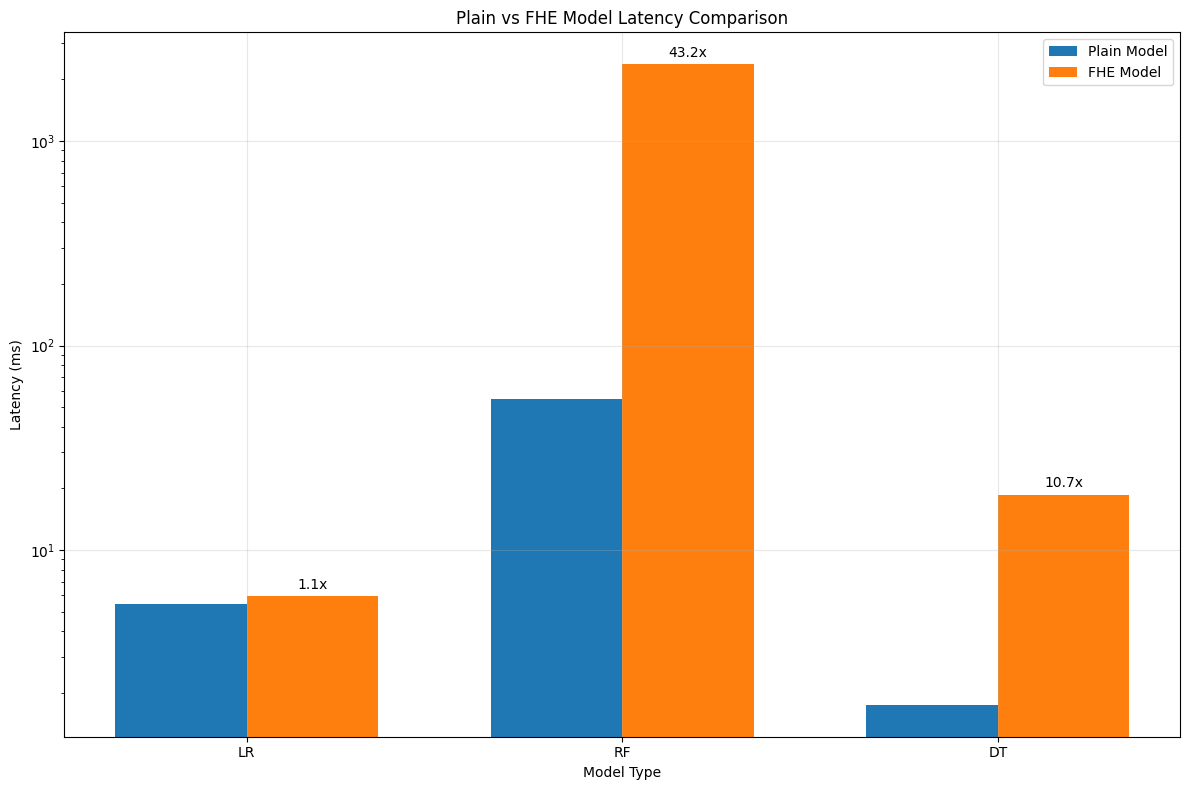


Logistic Regression - Best bit width: 3
Accuracy difference: -0.0001
Latency overhead: 1.09x


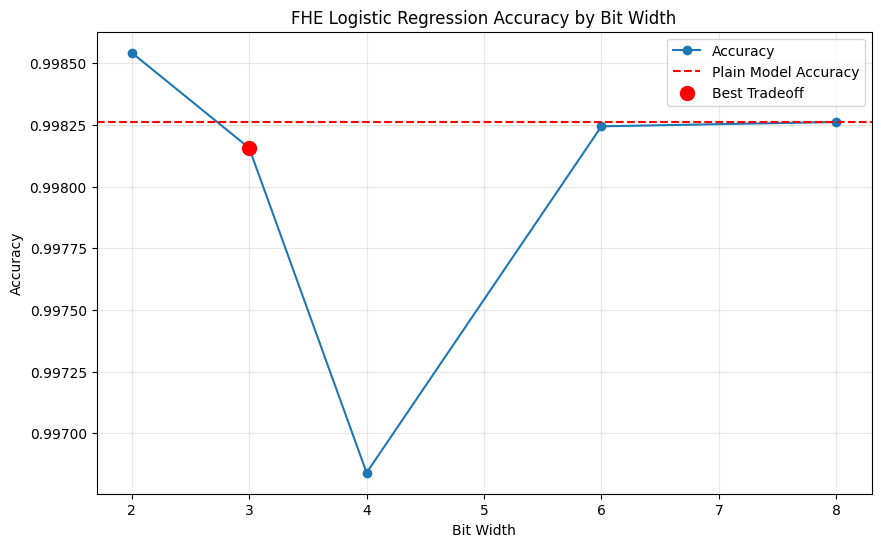


Writing summary report...
Evaluation complete! Results saved to 'fhe_evaluation_report.txt'


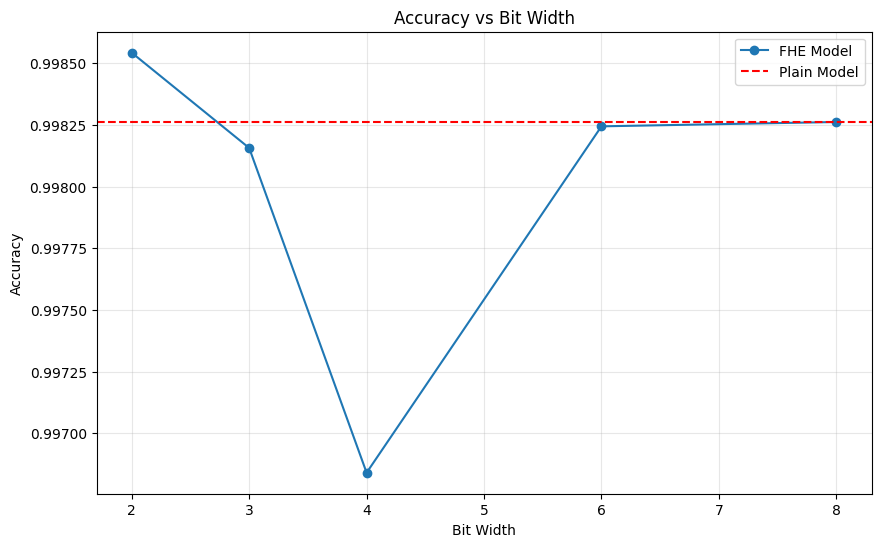

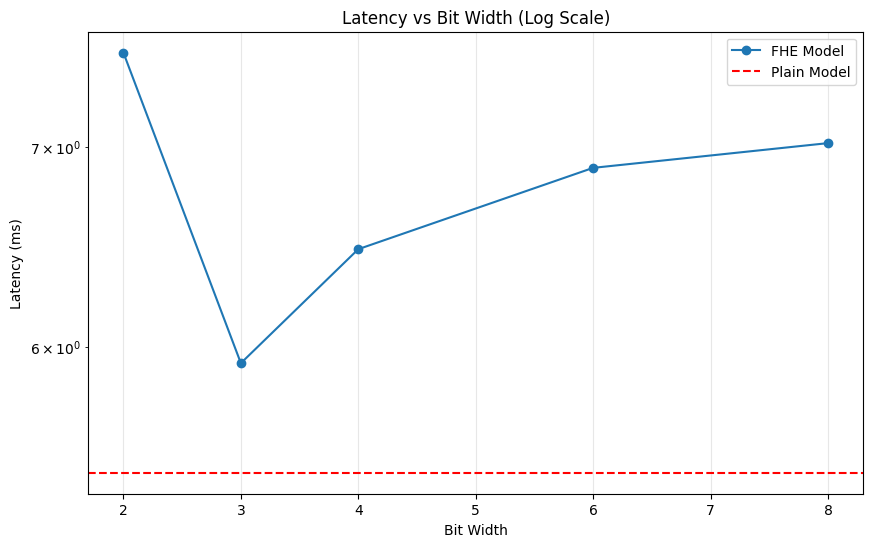

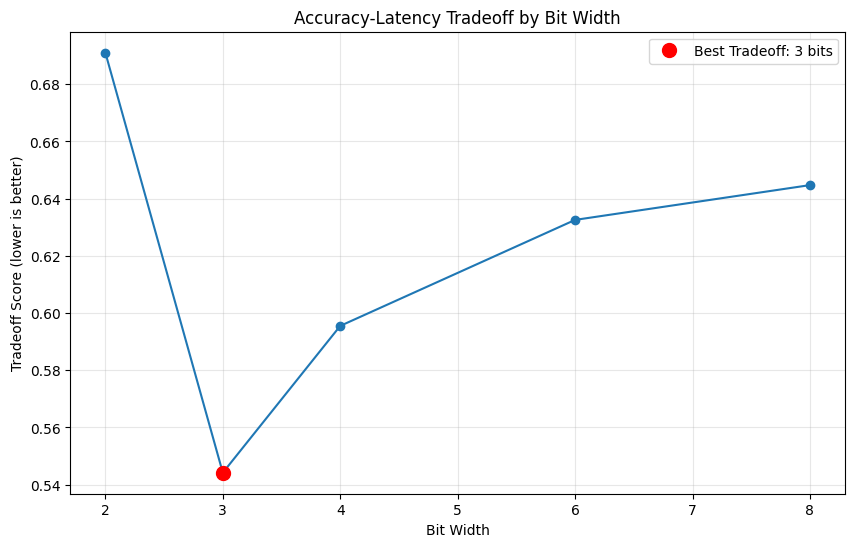

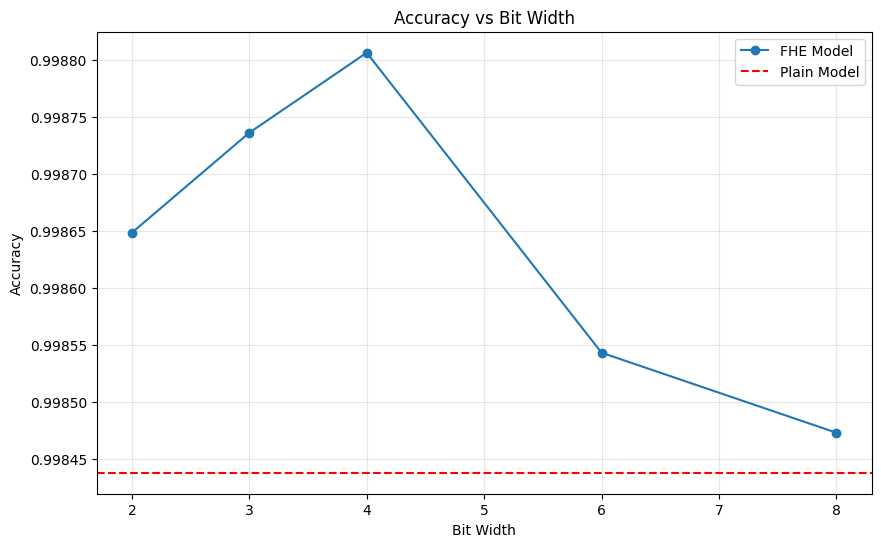

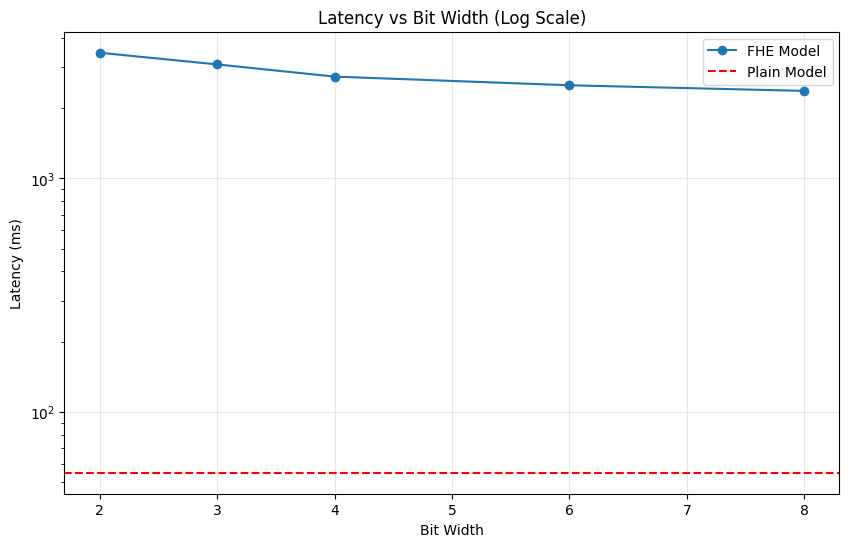

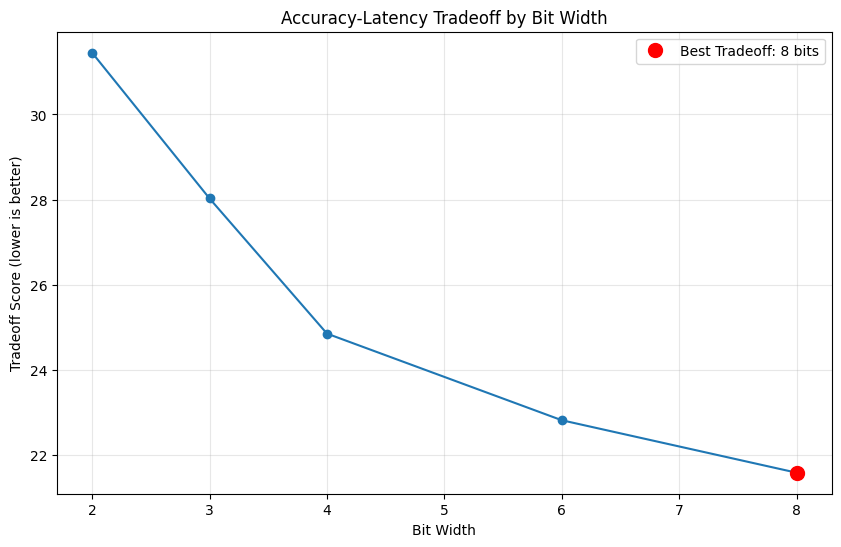

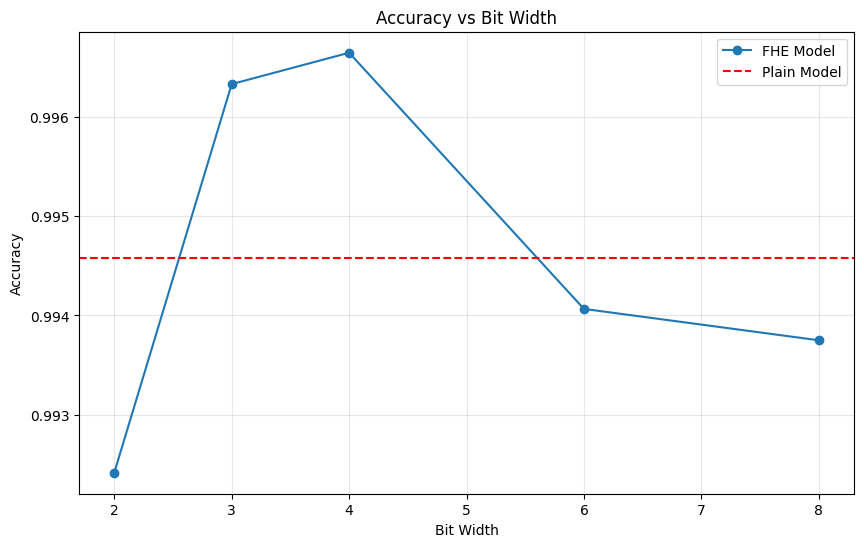

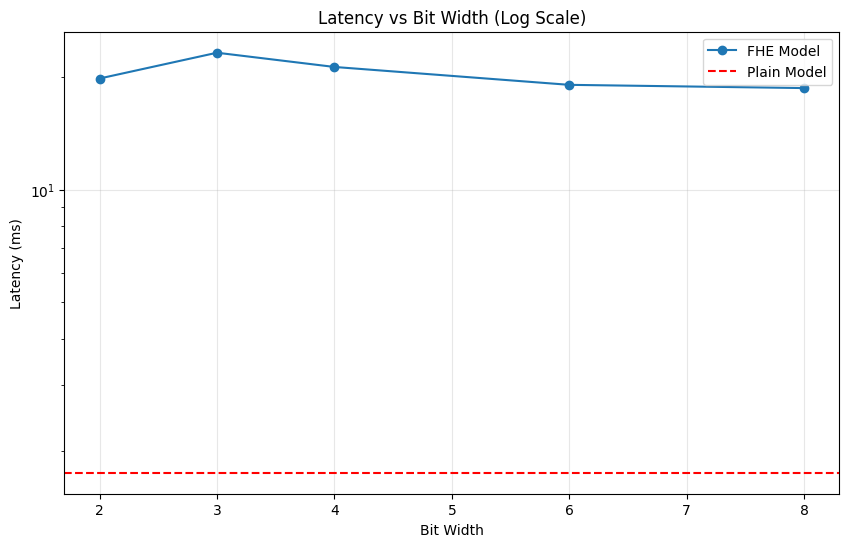

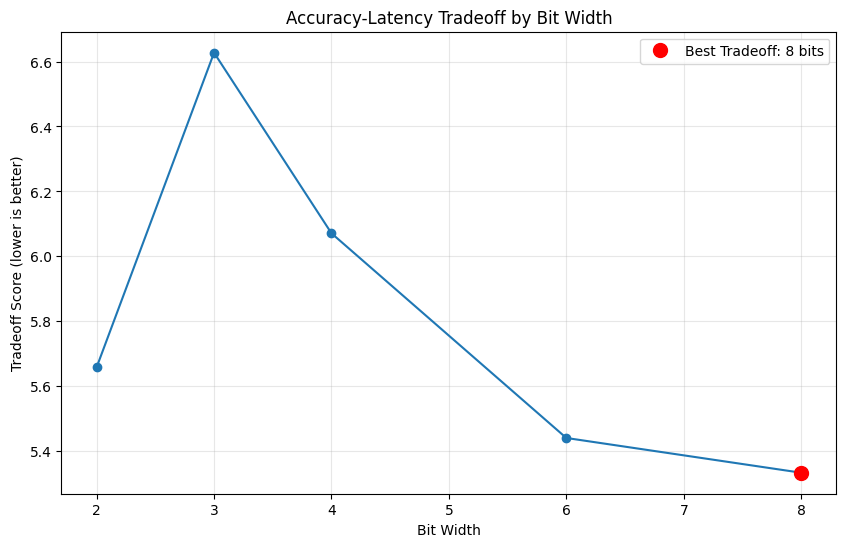

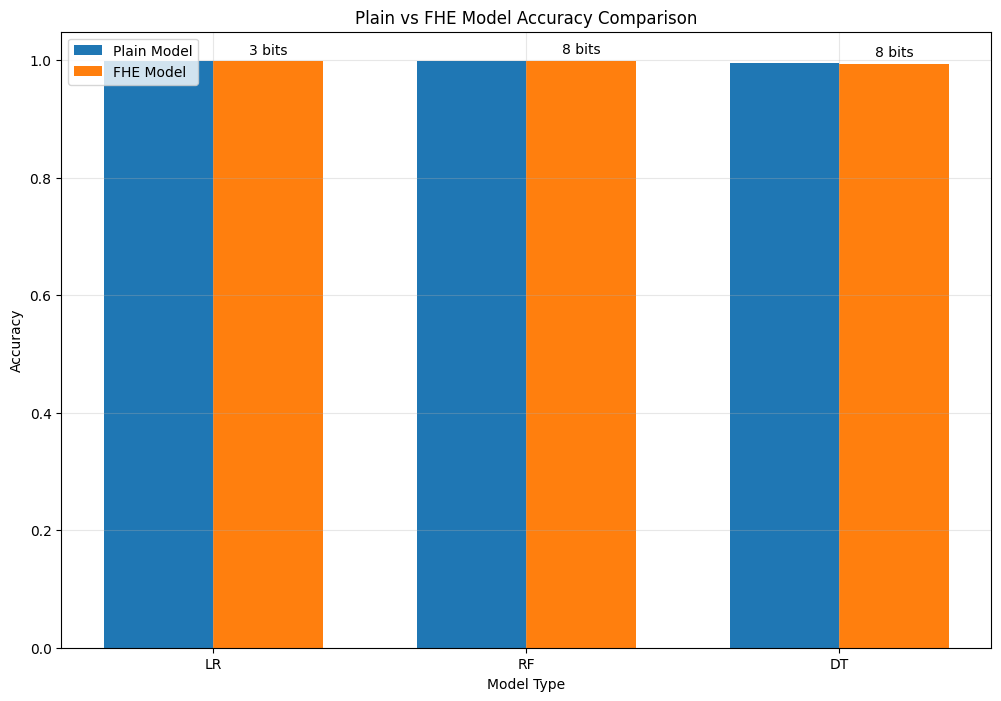

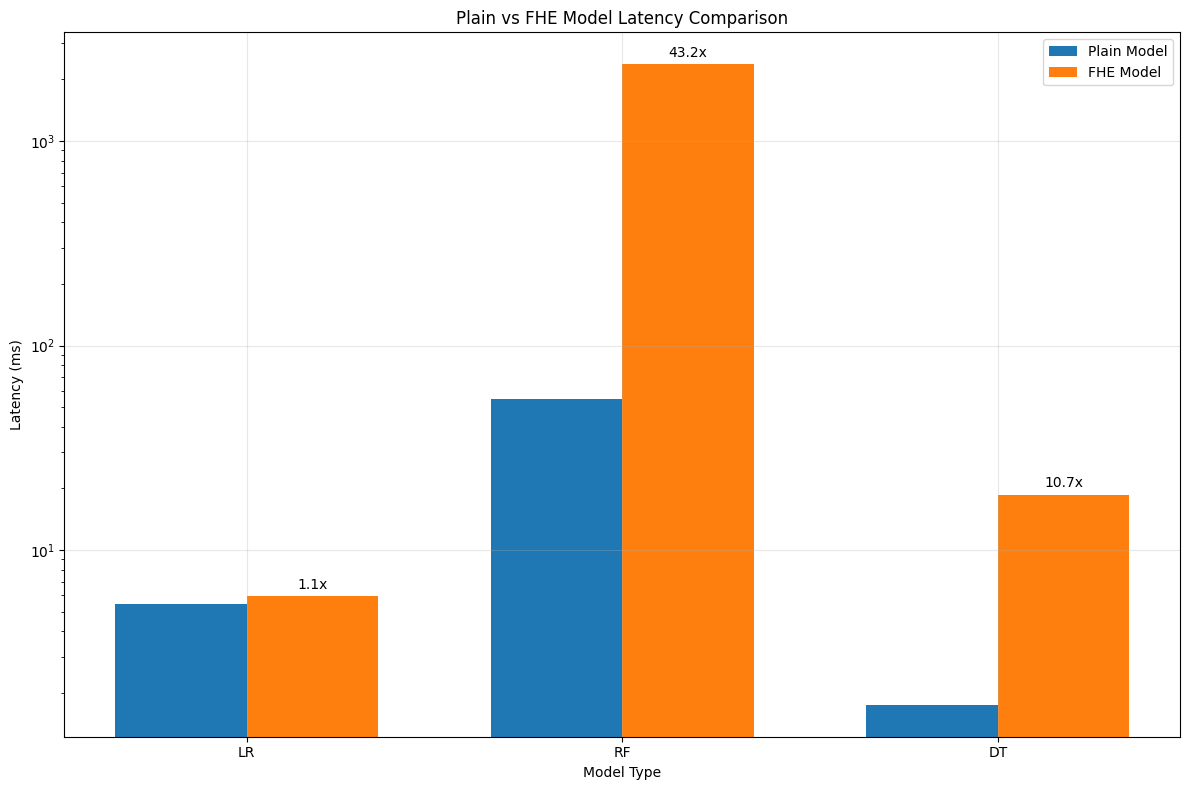

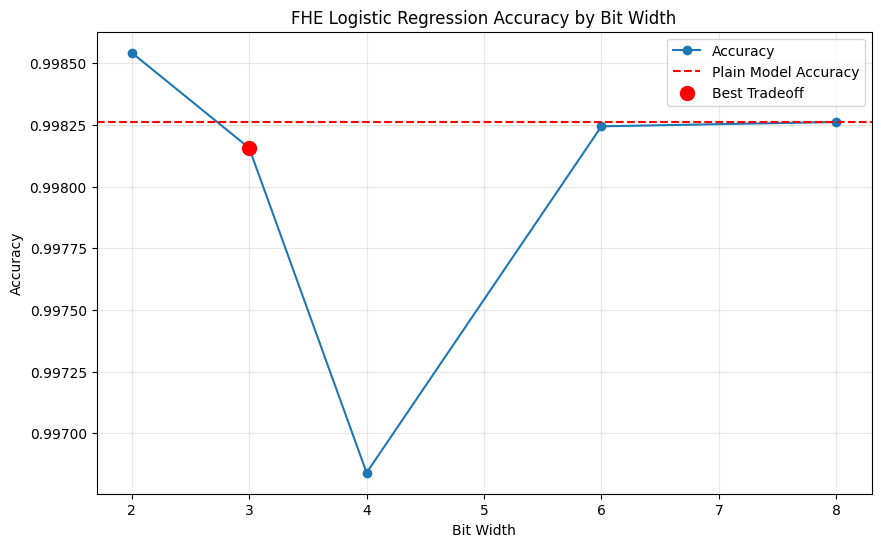

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

# Import the FHE Model Evaluator
from fhe_model_evaluator import FHEModelEvaluator

# Load the credit card fraud dataset
# The dataset contains transactions with 'Time', 'Amount' and V1-V28 features
# 'Class' is the target variable (1 = fraud, 0 = normal)
print("Loading credit card fraud dataset...")
df = pd.read_csv('creditcard.csv')

print(f"Dataset shape: {df.shape}")
print(f"Fraud cases: {df['Class'].sum()} ({df['Class'].mean()*100:.2f}%)")

print("Preprocessing data...")

X = df.drop('Class', axis=1).values
y = df['Class'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

evaluator = FHEModelEvaluator(random_state=42, verbose=True)

param_grids = {
    'lr': {
        'C': [0.01, 0.1, 1.0, 10.0],
        'penalty': ['l2'],
        'solver': ['liblinear']
    },
    'rf': {
        'n_estimators': [10, 50, 100],
        'max_depth': [3, 5, 7],
        'min_samples_leaf': [1, 3, 5]
    },
    'dt': {
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

model_types = ['lr', 'rf', 'dt']

undersampler = RandomUnderSampler(sampling_strategy=0.1, random_state=42)

best_params = {}
print("\nPerforming grid search for optimal parameters...")
for model_type in model_types:
    print(f"\nGrid search for {model_type.upper()}...")
    result = evaluator.grid_search(
        model_type=model_type,
        param_grid=param_grids[model_type],
        x=X_train,
        y=y_train,
        undersampler=undersampler,
        cv=3,  
        scoring='f1'  
    )
    best_params[model_type] = result['best_params']
    
print("\nBest parameters:")
for model_type, params in best_params.items():
    print(f"{model_type.upper()}: {params}")

bit_widths = [2, 3, 4, 6, 8]

print("\nEvaluating FHE vs plain text models...")
evaluation_results = evaluator.evaluate_models(
    model_types=model_types,
    x=X_test,  
    y=y_test,
    best_params=best_params,
    bit_widths=bit_widths,
    undersampler=undersampler,
    cv_splits=3,  # Reduced CV folds for faster execution
    n_iterations=50  # Reduced iterations for faster latency measurement
)

print("\nFHE vs Plain Model Comparison Summary:")
print(evaluation_results['summary']['comparison_table'])

acc_fig, latency_fig = evaluator.visualize_model_comparison()

try:
    from IPython.display import display
    display(acc_fig)
    display(latency_fig)
except ImportError:
    acc_fig.savefig('fhe_accuracy_comparison.png')
    latency_fig.savefig('fhe_latency_comparison.png')
    print("Saved visualization figures to 'fhe_accuracy_comparison.png' and 'fhe_latency_comparison.png'")

lr_comparison = evaluation_results['model_comparison']['lr']['comparison']
print(f"\nLogistic Regression - Best bit width: {lr_comparison['best_bit_width']}")
print(f"Accuracy difference: {lr_comparison['accuracy_diffs'][lr_comparison['best_tradeoff_idx']]:.4f}")
print(f"Latency overhead: {lr_comparison['latency_ratios'][lr_comparison['best_tradeoff_idx']]:.2f}x")

best_lr_idx = lr_comparison['best_tradeoff_idx']
lr_bit_widths = evaluation_results['model_comparison']['lr']['cipher_results']['bit_widths']
lr_accuracies = evaluation_results['model_comparison']['lr']['cipher_results']['accuracies']
lr_latencies = evaluation_results['model_comparison']['lr']['cipher_results']['latencies']

plt.figure(figsize=(10, 6))
plt.plot(lr_bit_widths, lr_accuracies, 'o-', label='Accuracy')
plt.axhline(
    y=evaluation_results['model_comparison']['lr']['plain_results']['avg_accuracy'],
    color='r', linestyle='--', label='Plain Model Accuracy'
)
plt.scatter(
    lr_bit_widths[best_lr_idx], 
    lr_accuracies[best_lr_idx], 
    color='red', s=100, zorder=5, label='Best Tradeoff'
)
plt.xlabel('Bit Width')
plt.ylabel('Accuracy')
plt.title('FHE Logistic Regression Accuracy by Bit Width')
plt.grid(True, alpha=0.3)
plt.legend()

# Save or display the plot
try:
    from IPython.display import display
    display(plt.gcf())
except ImportError:
    plt.savefig('lr_bit_width_impact.png')
    print("Saved LR bit width impact figure to 'lr_bit_width_impact.png'")

# Example of creating a summary report
print("\nWriting summary report...")
with open('fhe_evaluation_report.txt', 'w') as f:
    f.write("FHE vs Plain Model Evaluation Report\n")
    f.write("=" * 40 + "\n\n")
    
    f.write("Dataset: Credit Card Fraud Detection\n")
    f.write(f"Total samples: {len(df)}\n")
    f.write(f"Fraud cases: {df['Class'].sum()} ({df['Class'].mean()*100:.2f}%)\n\n")
    
    f.write("Model Parameters:\n")
    for model_type, params in best_params.items():
        f.write(f"{model_type.upper()}: {params}\n")
    f.write("\n")
    
    f.write("FHE Evaluation Results:\n")
    f.write(f"Best model by accuracy: {evaluation_results['summary']['best_accuracy_model'].upper()}\n")
    f.write(f"Best model by latency: {evaluation_results['summary']['best_latency_model'].upper()}\n")
    f.write(f"Best model by overhead: {evaluation_results['summary']['best_overhead_model'].upper()}\n\n")
    
    f.write("Model Comparison Table:\n")
    f.write(evaluation_results['summary']['comparison_table'].to_string())
    f.write("\n\n")
    
    f.write("FHE Bit Width Impact:\n")
    for model_type in model_types:
        bit_width_impact = evaluation_results['model_comparison'][model_type]['comparison']
        f.write(f"{model_type.upper()} - Best bit width: {bit_width_impact['best_bit_width']}\n")
        accuracies = evaluation_results['model_comparison'][model_type]['cipher_results']['accuracies']
        latencies = evaluation_results['model_comparison'][model_type]['cipher_results']['latencies']
        
        for i, bw in enumerate(bit_widths):
            f.write(f"  {bw} bits: Accuracy={accuracies[i]:.4f}, Latency={latencies[i]:.2f}ms, "
                   f"Overhead={bit_width_impact['latency_ratios'][i]:.2f}x\n")
        f.write("\n")

print("Evaluation complete! Results saved to 'fhe_evaluation_report.txt'")

FHE Model Evaluator initialized
Processing data...
Dataset shape: (284807, 31)
Target distribution: Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64
Training set: (227845, 30), Test set: (56962, 30)

Performing grid search for optimal parameters...

Grid search for LR...
Performing grid search for LR model...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.9066

Grid search for RF...
Performing grid search for RF model...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'max_depth': 7, 'min_samples_leaf': 3, 'n_estimators': 100}
Best score: 0.9093

Grid search for DT...
Performing grid search for DT model...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best score: 0.8987

Evaluating FHE vs plain text models...

--------------------------------------

TypeError: unsupported format string passed to Series.__format__

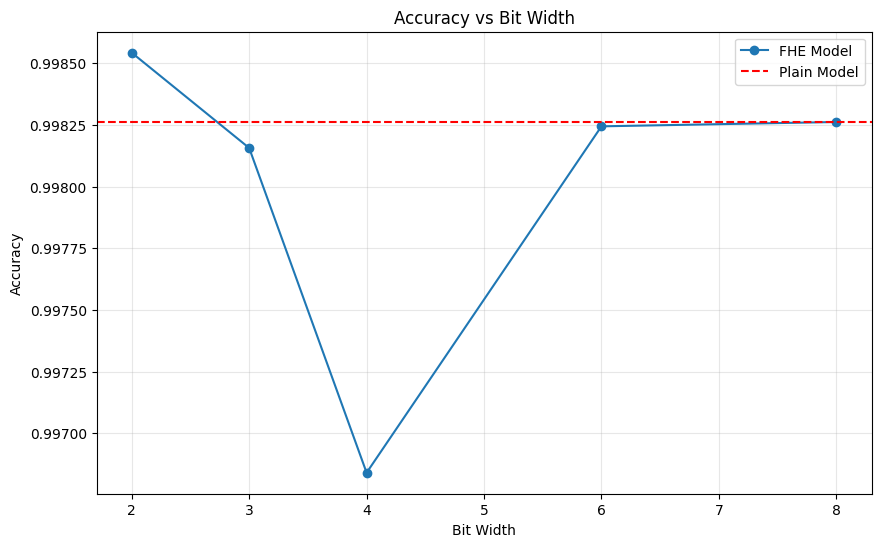

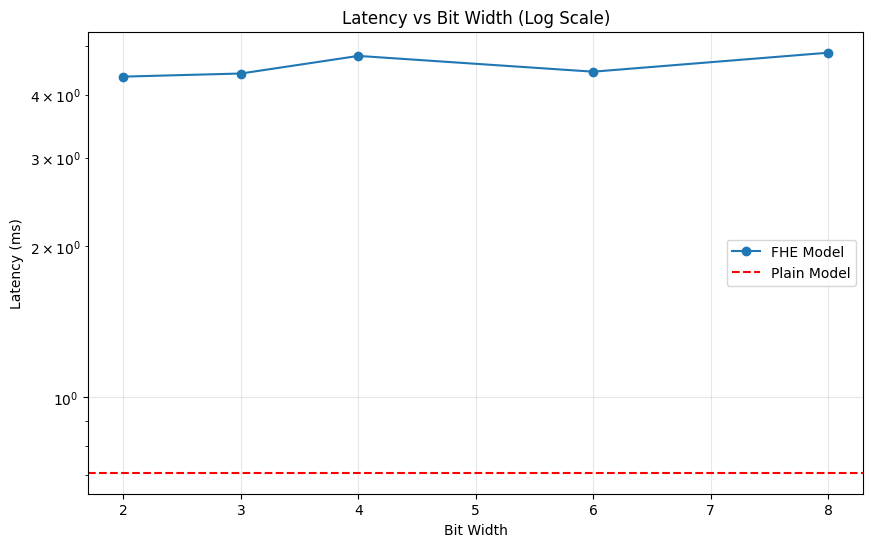

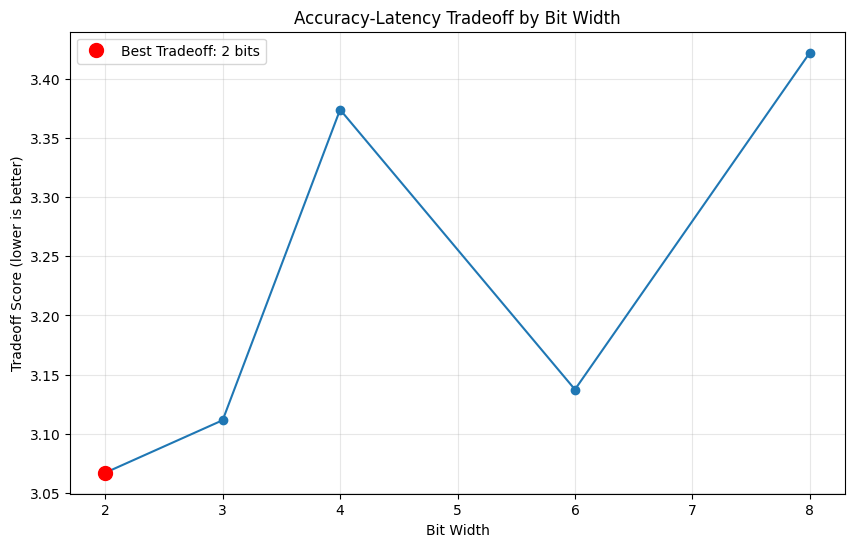

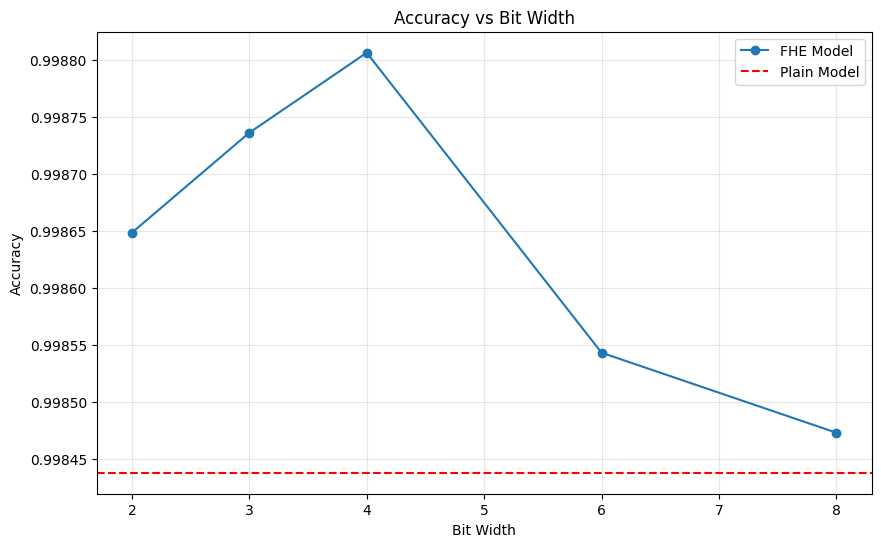

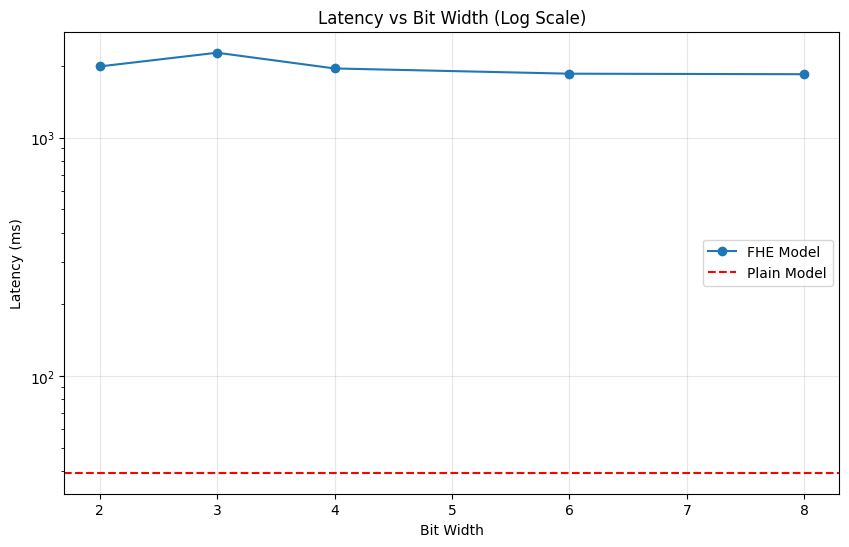

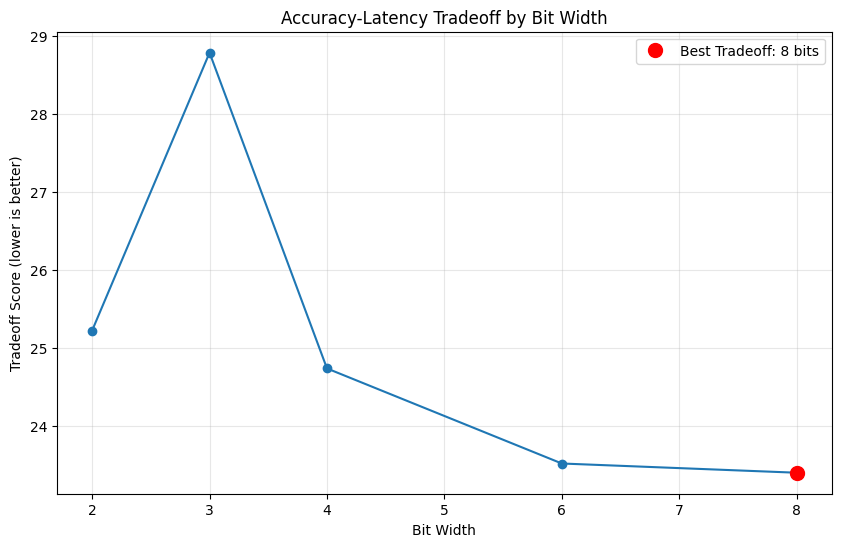

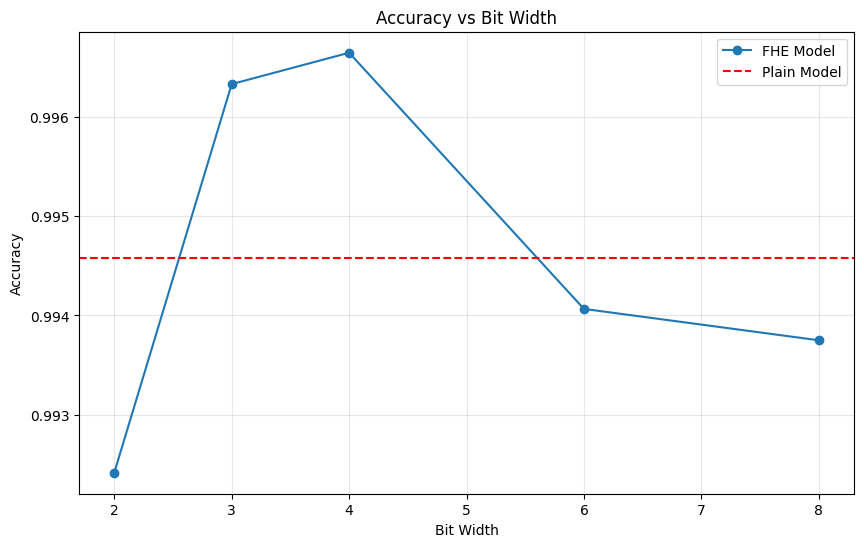

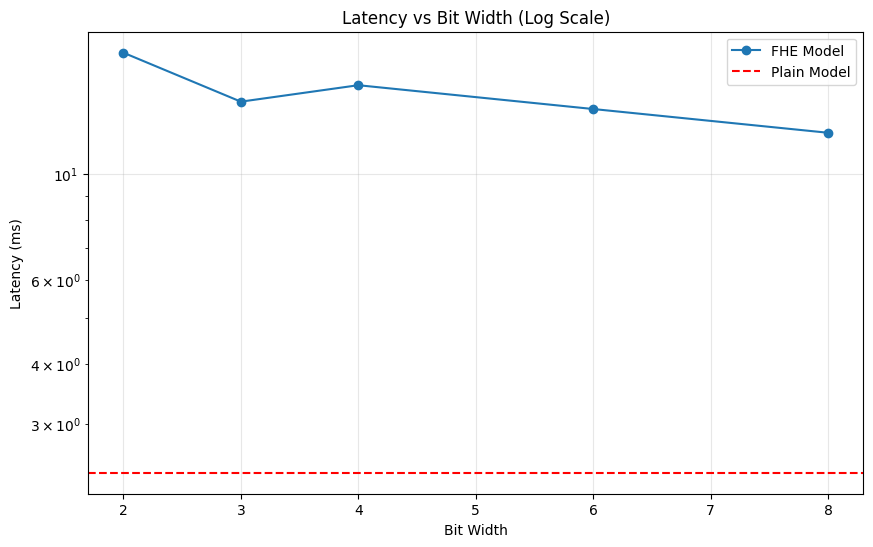

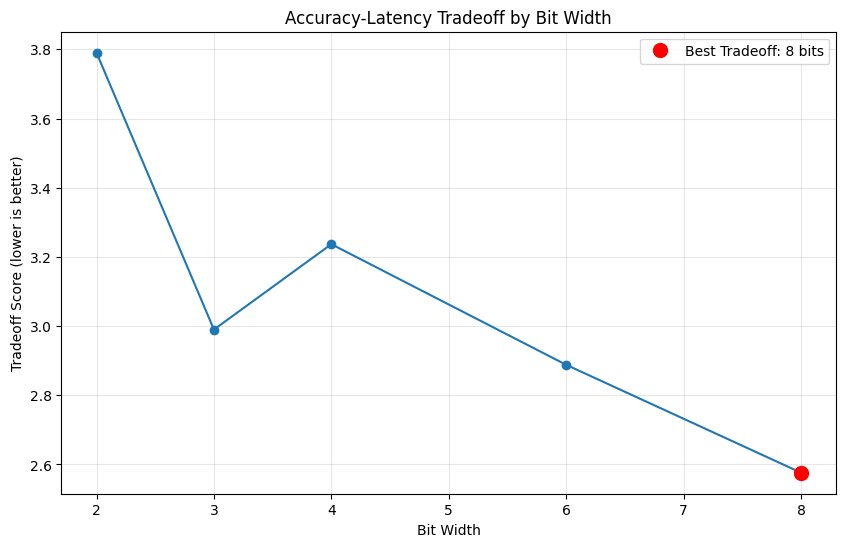

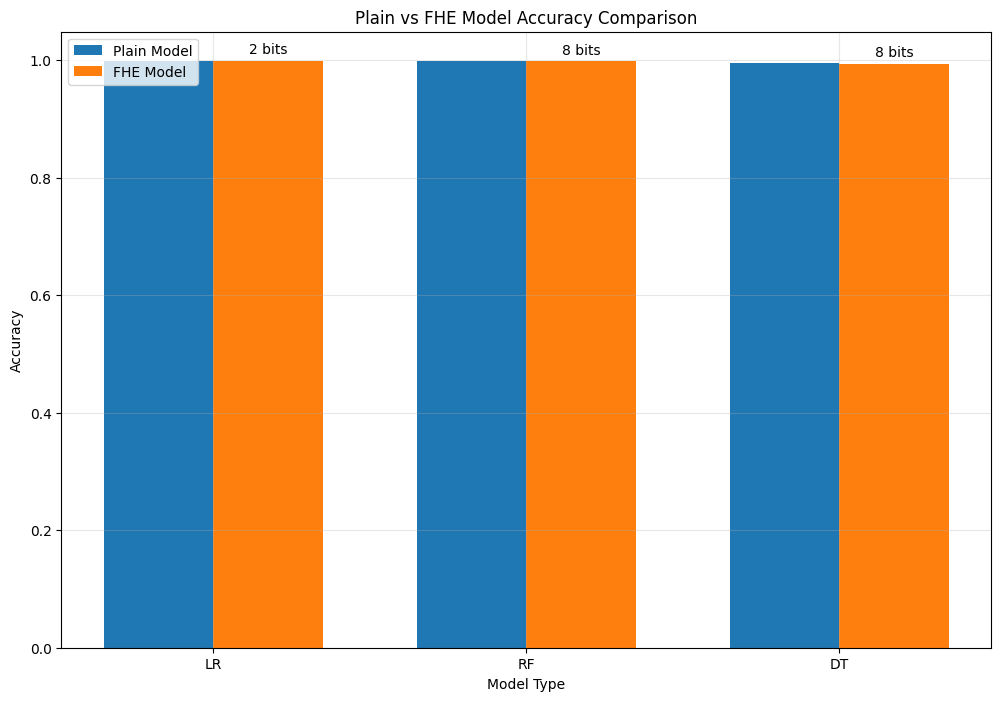

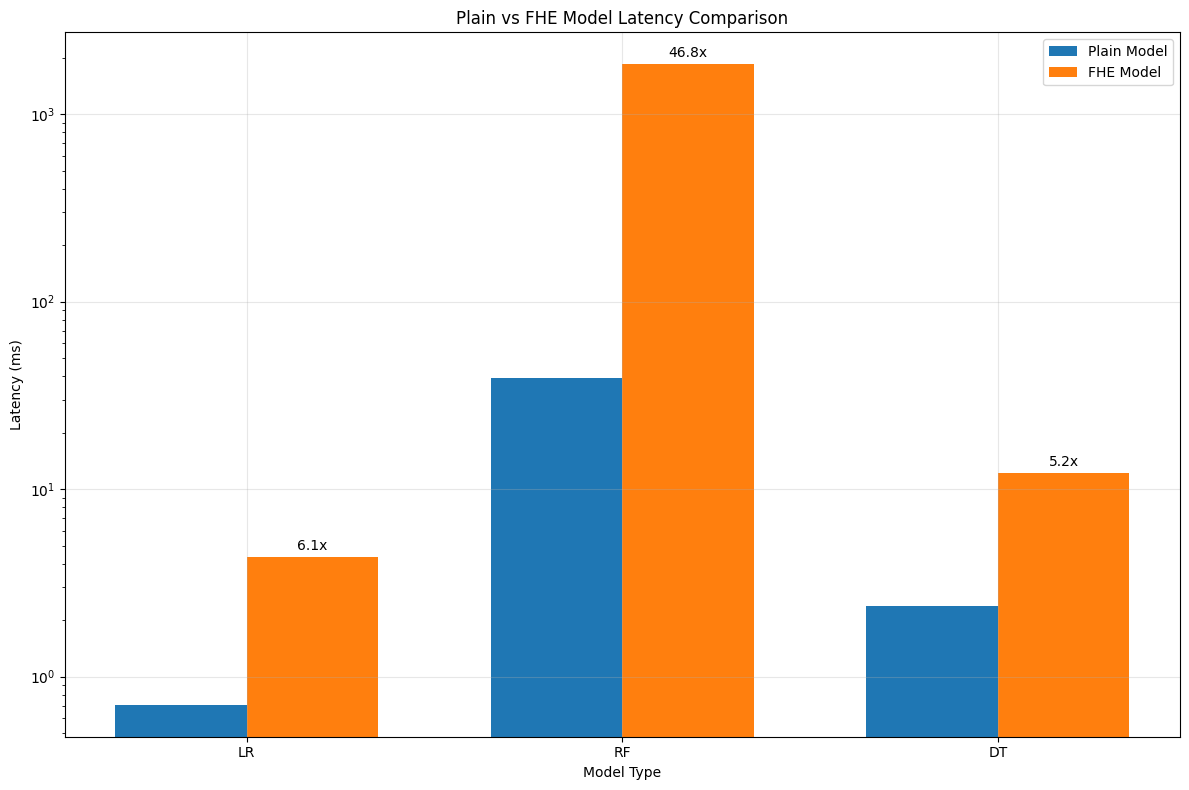

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

# Import the FHE Model Evaluator
from fhe_model_evaluator import FHEModelEvaluator

# Load data
df = pd.read_csv('creditcard.csv')

# Create evaluator with all configurations
evaluator = FHEModelEvaluator(
    data=df,                    
    target_column='Class',    
    random_state=42,
    verbose=True,
    test_size=0.2,
    undersampling_ratio=0.1,
    scaling=True,
    model_types=['lr', 'rf', 'dt'],
    bit_widths=[2, 3, 4, 6, 8],
    cv_folds=3,
    n_iterations=50
)

# Run the full pipeline
results = evaluator.run_full_pipeline()

# Generate report and visualizations
acc_fig, latency_fig, model_figures = evaluator.generate_report()